# Uitleg en voorbeelden van Decision Trees

In dit document geef ik een aantal voorbeelden van wanneer Decision Trees handig zijn, hoe ze eruit zien en wat de voordelen en nadelen van deze methode zijn. Dit is bedoeld als addendum bij het derde practicum van Declarative Programming. Ik ga hier expres niet in op de stappen waarmee een Decision Tree wordt opgebouwd; die implementeren we tijdens het practicum zelf!

Gedurende het practicum bouwen we de "basisvariant" van het Decision Tree algoritme; dat wil zeggen, de variant voor classificatietaken, op basis van de defaultparameters die gebruikt worden door de Scikit-Learn-implementatie. We gaan hier dus een classificatieprobleem oplossen, maar er zijn talloze varianten van dit algoritme, ook voor regressietaken!


In [224]:
from sklearn.datasets import load_iris
from sklearn import tree
import graphviz 
import matplotlib.pyplot as plt
import numpy as np

# Helperfunctie voor visualisaties.
def scatterplot(values, classes, lines=[]):
    fig, ax = plt.subplots()
    xs = list(map(lambda x: x[0], values))
    ys = list(map(lambda x: x[1], values))
    colordict = {"blue": "#2527ba", "green": "#32ba25"}
    cs = list(map(lambda x: colordict[x], classes))
    ax.scatter(xs, ys, c=cs)
    for line in lines:
        ax.plot(line[0], line[1], 'k--')
    plt.show()

def dtc(properties, classes):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(properties, classes)
    return clf

# Helperfunctie voor Decision Tree classificatietaken.
def dtc_graph(properties, classes, featurenames=["X", "Y"], classnames=["blue", "green"]):
    clf = dtc(properties, classes)
    dot_data = tree.export_graphviz(clf, out_file=None, feature_names=featurenames, class_names=classnames, filled=True, rounded=True, special_characters=True)  
    graph = graphviz.Source(dot_data) 
    return graph

# Helperfunctie voor het visualiseren van de scheidslijnen van een Decision Tree.
def separatorlines(clf, target=0, minx=1, maxx=10, miny=1, maxy=10):
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    if children_left[target] == children_right[target]:
        return []
    lines = []
    if feature[target] == 0:
        lines.append([[threshold[target],threshold[target]],[miny, maxy]])
        lines += separatorlines(clf, children_left[target], minx, threshold[target], miny, maxy)
        lines += separatorlines(clf, children_right[target], threshold[target], maxx, miny, maxy)
    else:
        lines.append([[minx, maxx],[threshold[target], threshold[target]]])
        lines += separatorlines(clf, children_left[target], minx, maxx, miny, threshold[target])
        lines += separatorlines(clf, children_right[target], minx, maxx, threshold[target], maxy)
    return lines

Stel, we hebben de onderstaande data; de waarden uit properties_example_1 (in de plot: x en y) vertegenwoordigen de eigenschappen van elk meetpunt, en de bijbehorende waarde uit classes_example_1 (in de plot: blauw en groen) vertegenwoordigt de klasse die we willen voorspellen. Gegeven een willekeurig punt uit deze ruimte, zoals (2,7), welke kleur voorspel je dat er bij dat punt hoort? Waarom?

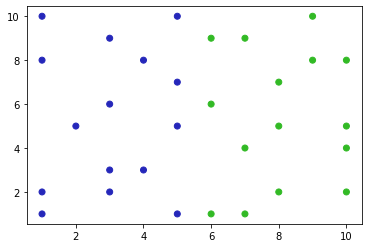

In [226]:
properties_example_1 = np.array([[1,1],[3,2],[3,3],[1,10],[5,5],[1,8],[5,10],[4,3],[5,7],[1,2],[2,5],[3,9],[4,8],[3,6],[5,1],[6,6],[7,9],[8,2],[9,10],[10,4],[7,4],[8,5],[6,1],[10,2],[10,8],[6,9],[8,7],[10,5],[9,8],[7,1]])
classes_example_1 = np.array(["blue","blue","blue","blue","blue","blue","blue","blue","blue","blue","blue","blue","blue","blue","blue","green","green","green","green","green","green","green","green","green","green","green","green","green","green","green"])
scatterplot(properties_example_1, classes_example_1)

Dit is een eenvoudige situatie; op basis van de data die we tot dusver hebben, lijkt het erop dat alle x-waarden boven de 5 een groen punt tot gevolg hebben, en alles onder of gelijk aan 5 een blauw punt geeft. De y-waarde lijkt geen effect te hebben.

Als we dus een model zouden moeten schrijven dat de waarde van een nieuw datapunt voorspelt, zou die een verticale lijn kunnen trekken op x=5 - of beter nog, op x=5.5, want dan zitten we precies tussen onze observaties tot dusver in. Gevisualiseerd:

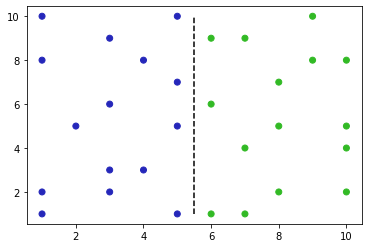

In [228]:
scatterplot(properties_example_1, classes_example_1, [[[5.5,5.5],[1,10]]])

Als we deze data doorgeven aan de Decision Tree Classifier, gaat deze achter de schermen op zoek naar welke splitsing de klassen het beste van elkaar scheidt, en komt deze inderdaad op de lijn die we hierboven hebben geschetst. 

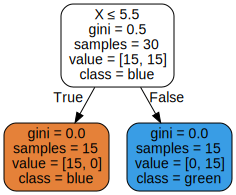

In [230]:
dtc_graph(properties_example_1, classes_example_1)

Qua structuur en qua conclusies is de bovenstaande boom hopelijk al logisch, maar laten we even in detail ingaan op enkele van de eigenschappen die je hierboven ziet:

- Deze Decision Trees splitsen op één eigenschap tegelijkertijd (niet dat dat verschil maakt; je kunt een boom die splitst op meerdere eigenschappen tegelijkertijd omschrijven naar functioneel dezelfde boom die op één eigenschap per keer splitst);
- Deze Decision Trees splitsen op een grenswaarde, niet op een complexere grensfunctie. (Dadelijk gaan we in meer detail zien waarom dat een beperking is, maar houd het voor nu even in gedachten.) In twee dimensies kun je de scheiding bij een beslissing daarom voor je zien als een horizontale of verticale lijn; in drie dimensies wordt het een scheidsvlak, in vier dimensies een scheidskubus, etc. Om deze voorbeelden helder te houden beperken we ons hier tot twee dimensies, maar dat aantal maakt voor Decision Trees verder niet uit;
- We zien hier de introductie van "gini", hetgeen staat voor de "Gini impurity" - de mate van hoe "impuur", of "gemengd", de data is. Initieel is de dataset perfect gemengd; hij bevat precies evenveel voorbeelden van alle mogelijke klassen. Hier is de Gini impurity 0.5, op een schaal van 0 tot 1, met 1 het meest impuur. Elk van de twee datasets na de splitsing is perfect homogeen; elk bevat alléén maar voorbeelden van één van de klassen. Hier is de Gini impurity precies 0.0, de best mogelijke waarde.

Met die kennis in het achterhoofd herkleuren we een aantal van onze datapunten. Hoe kun je nu voorspellen welke kleur er bij een willekeurig punt hoort? Waarom? 

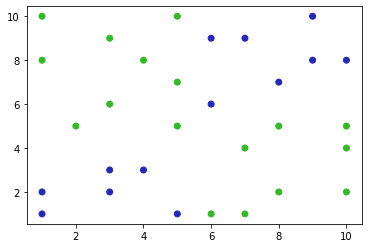

In [232]:
properties_example_2 = np.array([[1,1],[3,2],[3,3],[1,10],[5,5],[1,8],[5,10],[4,3],[5,7],[1,2],[2,5],[3,9],[4,8],[3,6],[5,1], \
                                 [6,6],[7,9],[8,2],[9,10],[10,4],[7,4],[8,5],[6,1],[10,2],[10,8],[6,9],[8,7],[10,5],[9,8],[7,1]])
classes_example_2 = np.array(["blue","blue","blue","green","green","green","green","blue","green","blue","green","green","green","green","blue", \
 "blue","blue","green","blue","green","green","green","green","green","blue","blue","blue","green","blue","green"])
scatterplot(properties_example_2, classes_example_2)


Dit is een situatie waarbij je allebei de eigenschappen van elk punt moet hebben om een passende voorspelling te doen. Een logische manier om dit aan te pakken zou zijn door eerst te splitsen op X-coordinaat (<= 5.5) en daarna op Y-coordinaat (<= 4 voor True en <= 5.5 voor False). Gevisualiseerd: 

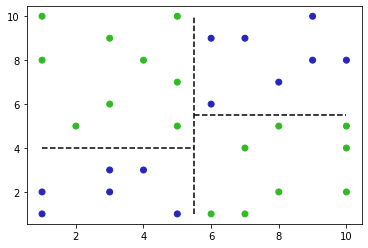

In [234]:
scatterplot(properties_example_2, classes_example_2, [[[5.5,5.5],[1,10]], [[1,5.5],[4,4]], [[5.5,10],[5.5,5.5]]])

Dit kun je vertalen naar een boom met precies vier bladeren, de kleinst mogelijke beslisboom voor deze situatie met perfecte precisie. Echter, als we deze data doorgeven aan de Decision Tree Classifier, zien we dat er net een andere boom uitkomt. Het algoritme kiest net andere splitsingen, mede omdat de dataset nu niet meer precies gebalanceerd is (niet meer 15 van elk, maar 13 blauw en 17 groen). Gevisualiseerd als boom:

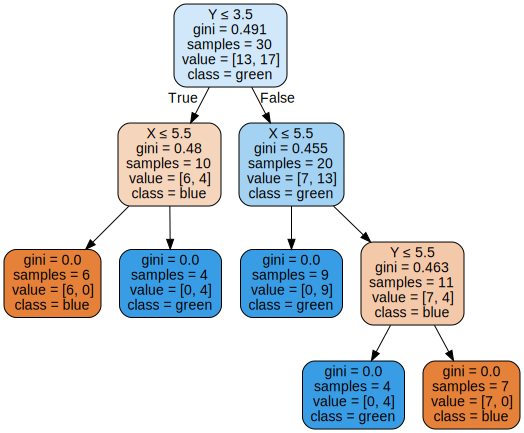

In [236]:
dtc_graph(properties_example_2, classes_example_2)

En als we de splitsingen in deze boom weergeven als scheidslijnen in de grafiek:

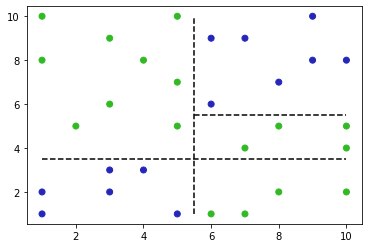

In [238]:
scatterplot(properties_example_2, classes_example_2, separatorlines(dtc(properties_example_2, classes_example_2)))

Dat we niet de "optimale" boom krijgen van de Decision Tree Classifier is in de praktijk geen probleem. Een voordeel van Decision Trees, nadat ze gebouwd zijn, is dat ze extreem snel afgelopen kunnen worden om een voorspelling te doen - de boom moet wel héél diep worden, eer dat proces te veel tijd kost.

Tevens is het een groot voordeel dat Decision Trees heel makkelijk te begrijpen zijn. (Ik hoop dat jullie dat met me eens zijn op basis van de voorgaande voorbeelden.) Zeker als we de boom uittekenen, kun je de redenering stap voor stap volgen. Dergelijke transparantie is een zeldzaam goed binnen data science.

Echter, Decision Trees hebben ook geprononceerde nadelen, die gelijk helder worden als we de Classifier een paar suboptimale voorbeelden voorschotelen. Neem bijvoorbeeld onderstaande herkleuring:

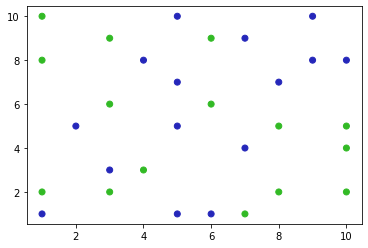

In [240]:
properties_example_3 = np.array([[1,1],[3,2],[3,3],[1,10],[5,5],[1,8],[5,10],[4,3],[5,7],[1,2],[2,5],[3,9],[4,8],[3,6],[5,1], \
                                 [6,6],[7,9],[8,2],[9,10],[10,4],[7,4],[8,5],[6,1],[10,2],[10,8],[6,9],[8,7],[10,5],[9,8],[7,1]])
classes_example_3 = np.array(["blue","green","blue","green","blue","green","blue","green","blue","green","blue","green","blue","green","blue", \
 "green","blue","green","blue","green","blue","green","blue","green","blue","green","blue","green","blue","green"])
scatterplot(properties_example_3, classes_example_3)

Hier mag je wel stellen dat er geen coherent verband te vinden is tussen de kleuren van deze punten. (Of misschien wel, maar dat verband zou absurd complex zijn.) Als we deze dataset doorgeven aan de Classifier, krijgen we:

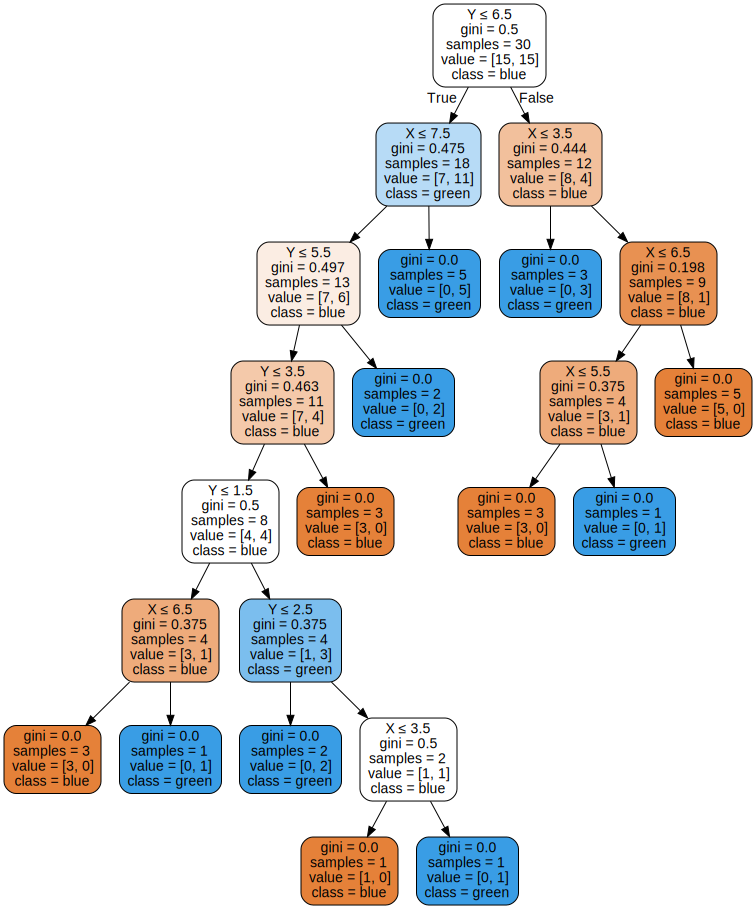

In [242]:
dtc_graph(properties_example_3, classes_example_3)

En dit gevisualiseerd met behulp van scheidslijnen ziet er als volgt uit:

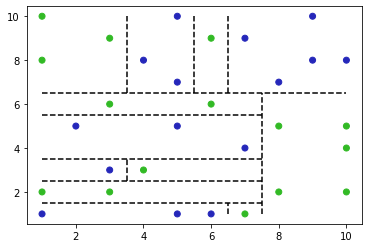

In [244]:
scatterplot(properties_example_3, classes_example_3, separatorlines(dtc(properties_example_3, classes_example_3)))

Je zou terecht kunnen zeggen dat dit een nogal flauw voorbeeld is; we geven een algoritme dat zoekt naar patronen immers data waar geen patroon in te vinden is. Maar het illustreert wel dat deze basisversie van de Decision Tree Classifier niet stopt voordat álle subsets perfect puur zijn - ook als er nog maar één datapunt in de subset zit. Dit is een algemeen risico van Decision Trees; ze overfitten erg snel.

Je kunt de Decision Tree Classifier een hoop parameters meegeven om dit probleem te voorkomen: maximum diepte van de boom, minimaal aantal datapunten nodig om te splitsen, minimale verbetering van de Gini impurity na de splitsing, etc. Ook zijn er legio technieken om meerdere Decision Trees te combineren tot één beslismodel (boosting, bagging, etc.). In de praktijk is men dus afhankelijk van de expertise van data scientists om deze techniek op de juiste plaats en manier te benutten.

In het practicum gaan we deze parameters en technieken niet implementeren. We bouwen dus een classifier waarvan we weten dat deze snel overfit.

Tot slot nog één voorbeeld, van een situatie die eenvoudig te visualiseren is, maar waar de Decision Tree Classifier moeite mee heeft:

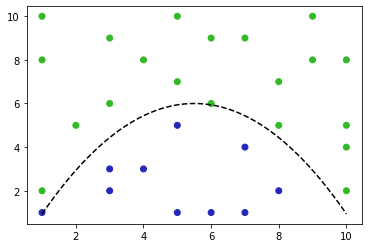

In [246]:
properties_example_4 = np.array([[1,1],[3,2],[3,3],[1,10],[5,5], [1,8],[5,10],[4,3],[5,7],[1,2], [2,5],[3,9],[4,8],[3,6],[5,1], \
                                 [6,6],[7,9],[8,2],[9,10],[10,4], [7,4],[8,5],[6,1],[10,2],[10,8], [6,9],[8,7],[10,5],[9,8],[7,1]])
classes_example_4 = np.array(["blue","blue","blue","green","blue", "green","green","blue","green","green", "green","green","green","green","blue", \
 "green","green","blue","green","green", "blue","green","blue","green","green", "green","green","green","green","blue"])
x = np.linspace(1, 10, 1000)
y = 6 - ((x-5.5)**2/4)
scatterplot(properties_example_4, classes_example_4, [[x,y]])

Hier hebben we een scheiding tussen de klassen die in de "werkelijkheid" (lees: zoals wij, de ontwerpers van dit probleem, weten) is gebaseerd op een parabool (specifiek, y = 6 - ((x-5.5)**2/4)). De Classifier maakt hier het volgende van:

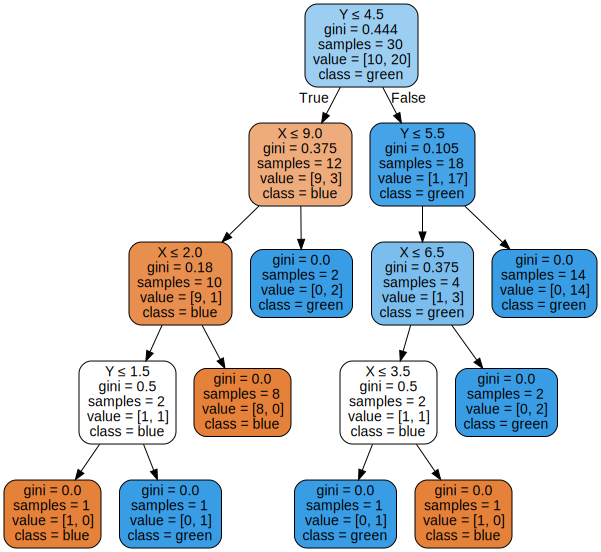

In [248]:
dtc_graph(properties_example_4, classes_example_4)

En gevisualiseerd als scheidslijnen:

In [ ]:
scatterplot(properties_example_4, classes_example_4, separatorlines(dtc(properties_example_4, classes_example_4)))

Is dit model te simpel? Te complex? Dat waardeoordeel laat ik aan jullie. In elk geval kan de Decision Tree Classifier het onderliggende verband niet direct benaderen met een polynome functie, alleen er omheen schetsen met rechte lijnen. Meer data maakt het model waarschijnlijk accurater, maar het lost het probleem van die "blokkerige scheidslijnen" niet op - het maakt de "blokjes" alleen kleiner. Voornamelijk toont dit aan dat Decision Trees simpelweg niet voor alle datasets de juiste oplossing zijn. Jullie inzicht als ontwikkelaars is cruciaal bij het bepalen wanneer Decision Trees handig zijn om toe te passen.

En dat was het! Voor Declarative Programming hebben jullie uiteraard niet de libraries die hiervoor zijn gebruikt (matplotlib, numpy, scikit-learn), maar hopelijk heeft dit verhaal jullie wel een gevoel gegeven voor wat Decision Trees zijn en waar jullie naartoe gaan werken. Bovendien komt het ook vast nog van pas bij Computational Modelling. In de overige bestanden van het project staan alle stappen in detail uitgelegd. Succes met het practicum!